In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from helpers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import clone
from sklearn import svm
from sklearn.svm import LinearSVC

seed = 42
verbose = 1
filename = "Counts_n10000_k5_s5000.csv"

lin_svc = svm.LinearSVC(max_iter=10000, random_state=seed)

In [4]:
y, X, _ = load_csv_data(filename)

X_freq = FREQ_transform(X)

Loading data...
Removing rows with less than n_min counts...
Data loaded!


In [10]:
from sklearn.cluster import KMeans

kmeans_X = X_freq.T
k_list = []
scores_list = []

for k in range(2,8):
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=seed).fit(kmeans_X)
    k_list.append(k)
    scores_list.append(kmeans.inertia_)
    

2
3
4
5
6
7


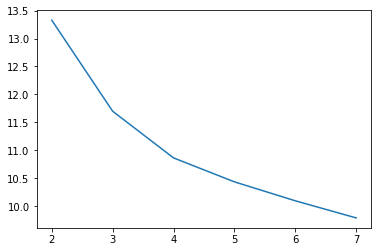

In [11]:
plt.plot(k_list,scores_list)

In [12]:
kmeans = KMeans(n_clusters=3, random_state=seed).fit(kmeans_X)
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)


In [23]:
print(list(set(kmeans.labels_)))
print(kmeans_X.shape[1])

[0, 1, 2]
18356


In [96]:
def create_kmeans_data(data, labels):
    kmeans_trans_X = np.empty((data.shape[0],len(set(labels))))
    
    labels_list = list(set(labels))
    for cluster_label in labels_list:
        cluster_cols = np.where(kmeans.labels_ == cluster_label)[0]
        cluster_sums = np.sum(data[:,cluster_cols], axis = 1)
        kmeans_trans_X[:,[cluster_label]] = np.expand_dims(cluster_sums,axis=1)
    return kmeans_trans_X

def kmeans_optimisation(X, y, method):
    X_t = X.T
    best_k = 0
    best_acc = [0,0,0]
    best_l_time = 0
    best_p_time = 0
    
    for k in [2,4,8,16,32,64,128,256,512,1024]:
        print('  - K-means, k = ' + str(k))
        t1 = time()
        kmeans = KMeans(n_clusters=k, random_state=seed).fit(X_t)
        kmeans_X = create_kmeans_data(X_freq, kmeans.labels_)
    
        X_train, X_test, y_train, y_test = train_test_split(kmeans_X, y, random_state=seed)
        lin_svc.fit(X_train, y_train)  
        t2 = time.time()
        y_pred = lin_svc.predict(X_test)
        t3 = time.time()
    
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        if bal_acc > best_acc[0]:
            best_k = k
            best_acc = [bal_acc, euk_accuracy(y_test, y_pred), pro_accuracy(y_test, y_pred)]
            best_l_time = t2 - t1
            best_p_time = t3 - t1
            
    return({'method':m, 'transformation': 'k-means',
               'accuracy':best_acc[0], 'euk_acc':best_acc[1], 'pro_acc':best_acc[2],
               'learning time':(t2 - t1), 'prediction time':(t3 - t2)})
    

In [108]:
import time
from sklearn.neural_network import MLPClassifier

X_t = X_freq.T
k_list = []
scores_list = []
time_list = []
nn = MLPClassifier(solver='adam', max_iter=200, random_state=seed)
lin_svc = svm.LinearSVC(C=100,max_iter=10000, random_state=seed)

for k in [200,250,300,350]:
    print('K-means, k = ' + str(k))
    kmeans = KMeans(n_clusters=k, random_state=seed).fit(X_t)
    kmeans_X = create_kmeans_data(X_freq, kmeans.labels_)
    
    X_train, X_test, y_train, y_test = train_test_split(kmeans_X, y, random_state=seed)
    lin_svc.fit(X_train, y_train)  
    t0 = time.time()
    y_pred = lin_svc.predict(X_test)
    t1 = time.time()
    el_time = t1 - t0
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    
    k_list.append(k)
    scores_list.append(bal_acc)
    time_list.append(el_time)

K-means, k = 200
K-means, k = 250
K-means, k = 300
K-means, k = 350


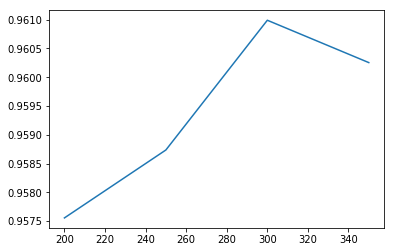

In [109]:
plt.plot(k_list, scores_list)

In [101]:
scores_list

[0.48046887431438373,
 0.8211542701361743,
 0.8569257550166696,
 0.9180198462072311,
 0.9269113381427923,
 0.9315466890077089,
 0.9338729436304065,
 0.9278116259051286,
 0.9205197934859503,
 0.909843638266831]